In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import copy
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from itertools import product
from tqdm.notebook import tqdm

In [44]:
def generate_mnist_loaders(batch_size: int) -> tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    # split into train and validation using 10k samples for validation
    train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    # this is very pedantic, but the validation (test) set was not constructed IID to training set
    # but we'll ignore that for now
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [45]:
def model_factory(layers: int, hidden_dim: int, input_dim: int, output_dim: int):
    model = nn.Sequential()
    model.add_module("flatten", nn.Flatten())
    model.add_module("in", nn.Linear(input_dim, hidden_dim))
    model.add_module("gelu_in", nn.GELU())
    for i in range(layers):
        model.add_module(f"layer_{i}", nn.Linear(hidden_dim, hidden_dim))
        model.add_module(f"gelu_{i}", nn.GELU())
    model.add_module("out", nn.Linear(hidden_dim, output_dim))
    return model


# FLOP Calculations
$$
\begin{gather}
FLOPs(N, L, H, I, O) = 3 (2 N I D + L (2 N D D) + 2 N D O) \\
= 6 \overbrace{N}^{\text{samples}} (\overbrace{I D + L D^2 + D O}^{\text{parameter count}})
\end{gather}
$$

In [46]:
def n_params(model: nn.Module) -> int:
    return sum(p.numel() for name, p in model.named_parameters() if name.endswith("weight"))

In [47]:
m = model_factory(1, 10, 28*28, 10)
assert n_params(m) == 28*28 * 10 + 1 * 10**2 + 10 * 10

In [56]:
def find_best_lr(model: nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, steps: int, device: str) -> float:
    model.to(device)
    lr_0 = 1 / (model[1].weight.size(0) ** 0.5) # 1 / sqrt(fan_in)
    lrs = [lr_0, lr_0 / 2, lr_0 / 4, lr_0 / 8, lr_0 / 16]
    best_loss = float("inf")
    best_lr = lr_0

    for lr in lrs:
        model_copy = copy.deepcopy(model)
        losses, val_loss = train_model(model_copy, train_loader, val_loader, steps, device, lr)
        # compute ema of losses
        beta = 0.9
        ema_losses = [losses[0]]
        for loss in losses[1:]:
            ema_losses.append(beta * ema_losses[-1] + (1 - beta) * loss)
        if ema_losses[-1] < best_loss:
            best_loss = ema_losses[-1]
            best_lr = lr
    return best_lr

def train_model(model: nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, steps: int, device: str, lr: float) -> tuple[list[float], float]:
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    losses = []
    pbar = tqdm(total=steps, position=1, leave=False)
    steps_completed = 0
    while True:
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch[0].to(device))
            loss = F.cross_entropy(output, batch[1].to(device))
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            steps_completed += 1
            pbar.update(1)
            pbar.set_description(f"Loss: {losses[-1]:.2f}")
            if steps_completed >= steps:
                break
        if steps_completed >= steps:
            break
    pbar.close()

    # compute validation loss
    val_losses = []
    for batch in val_loader:
        with torch.inference_mode():
            output = model(batch[0].to(device))
            loss = F.cross_entropy(output, batch[1].to(device), reduction="none")
        val_losses.append(loss.cpu().numpy())
    val_loss = np.mean(np.concatenate(val_losses))
    return losses, val_loss

def run_experiment(steps: int, hidden_dim: int, layers: int, batch_size: int, device: str) -> dict:
    train_loader, val_loader = generate_mnist_loaders(batch_size=batch_size)
    model = model_factory(layers, hidden_dim, 28*28, 10)
    lr = find_best_lr(model, train_loader, val_loader, 50, device)
    losses, val_loss = train_model(model, train_loader, val_loader, steps, device, lr)
    return {
        "steps": steps,
        "hidden_dim": hidden_dim,
        "layers": layers,
        "losses": losses,
        "val_loss": val_loss,
        "params": n_params(model),
    }


In [115]:
batch_size = 32
steps = [30000 // (batch_size * 2 ** (0.25 * i)) for i in range(9)]
hidden_dims = [int(16 * (2 ** (0.5 * i))) for i in range(12)]
layers = [2] # [1, 2]

configs = list(product(steps, hidden_dims, layers))

In [116]:
def run_experiment_wrapper(config):
    step, hidden_dim, layer = config
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    return run_experiment(step, hidden_dim, layer, batch_size, device)

In [125]:
from joblib import Parallel, delayed

runs = Parallel(n_jobs=4)(
    delayed(run_experiment_wrapper)(config)
    for config in tqdm(configs, total=len(configs))
)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/937.0 [00:00<?, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
  0%|          | 0/788.0 [00:00<?, ?it/s]
  0%|          | 0/788.0 [00:00<?, ?it/s]
  0%|          | 0/788.0 [00:00<?, ?it/s]
  0%|          | 0/788.0 [00:00<?, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
  0%|          | 0/788.0 [00:00<?, ?it/s]
  0%|          | 0/788.0 [00:00<?, ?it/s]
  0%|          | 0/788.0 [00:00<?, ?it/s]
  0%|  

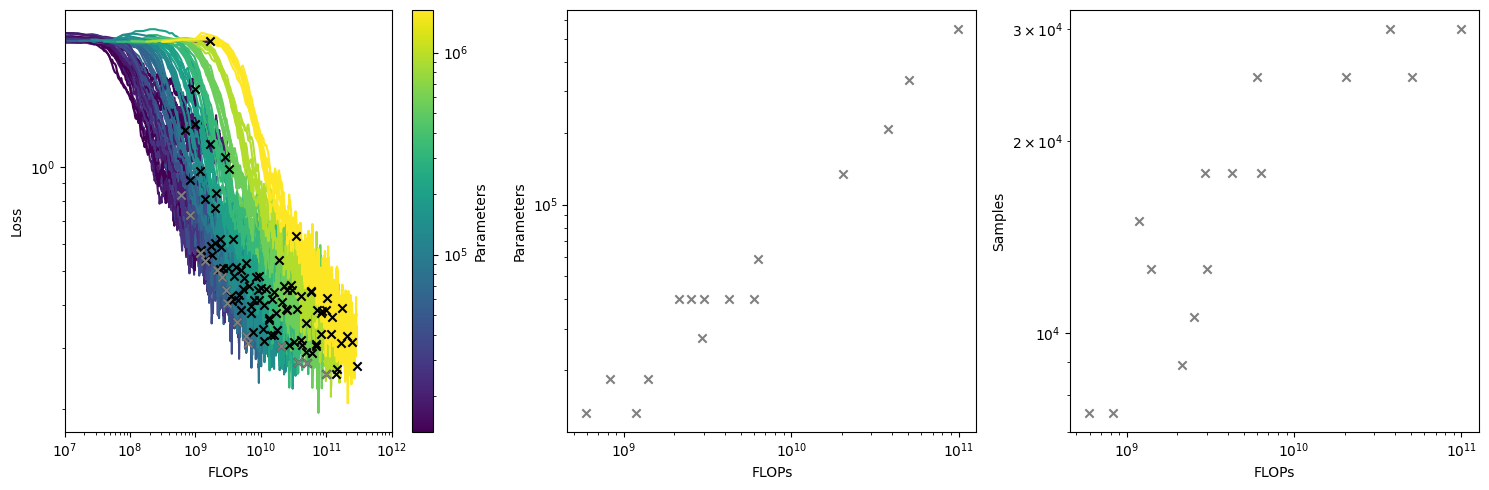

In [127]:
min_params = min(r['params'] for r in runs)
max_params = max(r['params'] for r in runs)
norm = colors.LogNorm(vmin=min_params, vmax=max_params)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
xmin, xmax = 1e7, 1e12

# First subplot - original loss plot
for run in runs:
    beta = 0.9
    loss_ema = [run["losses"][0]]
    for loss in run["losses"][1:]:
        loss_ema.append(beta * loss_ema[-1] + (1 - beta) * loss)
    xs = [batch_size * 6 * run["params"] * (i + 1) for i in range(len(loss_ema))]
    ax1.plot(xs, loss_ema, color=plt.cm.viridis(norm(run["params"])))

sorted_runs = sorted(runs, key=lambda x: x["params"] * x["steps"] * batch_size * 6)
envelope = [sorted_runs[0]]
for run in sorted_runs[1:]:
    if run["val_loss"] < envelope[-1]["val_loss"]:
        envelope.append(run)
ax1.scatter([x["steps"] * batch_size * 6 * x["params"] for x in runs], [x["val_loss"] for x in runs], color="k", zorder=10, marker="x")
ax1.scatter([x["steps"] * batch_size * 6 * x["params"] for x in envelope], [x["val_loss"] for x in envelope], color="gray", zorder=10, marker="x")
ax1.set_xlabel("FLOPs")
ax1.set_ylabel("Loss")
ax1.set_xlim(xmin, xmax)
ax1.set_xscale("log")
ax1.set_yscale("log")

# Second subplot - parameters
flops = np.array([x["steps"] * batch_size * 6 * x["params"] for x in envelope])
flop_threshold = 0 # 1e8
ax2.scatter(flops[flops > flop_threshold], [np.array([x["params"] for x in envelope])[flops > flop_threshold]], color="gray", marker="x")
ax2.set_xlabel("FLOPs")
ax2.set_ylabel("Parameters")
ax2.set_xscale("log")
ax2.set_yscale("log")

# Third subplot - samples
ax3.scatter(flops[flops > flop_threshold], np.array([x["steps"] * batch_size for x in envelope])[flops > flop_threshold], color="gray", marker="x")
ax3.set_xlabel("FLOPs")
ax3.set_ylabel("Samples")
ax3.set_xscale("log")
ax3.set_yscale("log")

sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label("Parameters")

plt.tight_layout()
plt.show()

Recalling that we can express loss as $\hat{L}(N,D)\triangleq E + \frac{A}{N^\alpha} + \frac{B}{D^\beta}$. We'll then use the L-BFGS optimizer to fit the parameters $E, A, B, \alpha, \beta$ to the data trying to minimize the loss: $\sum_{i=1}^n \text{Huber}_\delta(\log\hat{L}(N_i, D_i)- \log L(N_i, D_i))$.

In [149]:
class ParametricLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_E = nn.Parameter(torch.tensor(0.0))
        self.A = nn.Parameter(torch.tensor(0.0))
        self.B = nn.Parameter(torch.tensor(0.0))
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # we use exp to ensure that E is positive
        return torch.exp(self.log_E) + self.A / (x[:, 0] ** self.alpha) + self.B / (x[:, 1] ** self.beta)

    def huber_loss(self, x: torch.Tensor, y: torch.Tensor, delta: float = 1.0) -> torch.Tensor:
        x, y = torch.log(x), torch.log(y)
        return torch.sum(torch.where(torch.abs(x - y) < delta, 0.5 * (x - y) ** 2, delta * (torch.abs(x - y) - 0.5 * delta)))

loss_model = ParametricLoss()
optimizer = torch.optim.LBFGS(loss_model.parameters(), lr=1e-2)

runs_x = torch.tensor([[x["params"], x["steps"] * batch_size] for x in runs]) # [runs, 2]
runs_y = torch.tensor([x["val_loss"] for x in runs])

def closure():
    optimizer.zero_grad()
    loss_hat = loss_model.forward(runs_x)
    loss = loss_model.huber_loss(loss_hat, runs_y)
    loss.backward()
    return loss

for i in range(100):
    optimizer.step(closure)
    if i % 10 == 0:
        with torch.inference_mode():
            loss_hat = loss_model.forward(runs_x)
            loss = loss_model.huber_loss(loss_hat, runs_y)
            print(loss)

print(loss_model.log_E, loss_model.A, loss_model.B, loss_model.alpha, loss_model.beta)



tensor(29.0172)
tensor(8.9688)
tensor(8.6142)
tensor(8.6078)
tensor(8.6077)
tensor(8.6077)
tensor(8.6077)
tensor(8.6077)
tensor(8.6077)
tensor(8.6077)
Parameter containing:
tensor(-0.7969, requires_grad=True) Parameter containing:
tensor(0.0138, requires_grad=True) Parameter containing:
tensor(0.0048, requires_grad=True) Parameter containing:
tensor(0.9992, requires_grad=True) Parameter containing:
tensor(0.9999, requires_grad=True)
